In [1]:
%%capture
## Imports
import Imputation
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
import numpy as np 
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.ensemble import GradientBoostingRegressor
import seaborn as sns
import statsmodels.api as sm
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import svm
import dataframe_image as dfi


In [46]:
%%capture
## Data import

data = Imputation.data.reset_index()


In [47]:
data['area_num']

0          1.0
1          1.0
2          1.0
3          1.0
4          1.0
          ... 
1114289    0.0
1114290    0.0
1114291    0.0
1114292    0.0
1114293    0.0
Name: area_num, Length: 1114294, dtype: float64

In [48]:
## Filtering columns of interest
## endog - variable of interest
## exog - attributes, and cluster --city label
endog = ["post_secondary"]
exog = ["area_num", "has_received_human_dev_bond","female",
          "poverty_num", "age_st","extr_poverty_num","daily_hours_internet_use_st", "no_medical_insurance_num", "income_pc"]
clusters = ["city"]
data_filtered = data.loc[:, ["id_p"] + endog + exog + clusters].dropna(subset= ["id_p"] + endog + exog + clusters)
data_filtered.head()

,id_p,post_secondary,area_num,has_received_human_dev_bond,female,poverty_num,age_st,extr_poverty_num,daily_hours_internet_use_st,no_medical_insurance_num,income_pc,city
429172,01015199901401121,0,0.0,0.0,0,0,0.599912,0.0,-1.152376,0.0,227.399994,10151
429174,01015199901401121,0,0.0,0.0,0,0,-0.358866,0.0,-1.152376,0.0,227.399994,10151
429177,01015199901401131,0,0.0,0.0,0,0,0.006383,0.0,-1.152376,0.0,174.500000,10151
429178,01015199901401131,0,0.0,1.0,1,0,-0.084929,0.0,-1.152376,1.0,174.500000,10151
429184,01015199901402111,0,0.0,0.0,0,0,-0.130586,0.0,-1.152376,0.0,222.000000,10151


In [49]:
## Basic description of DataFrame
_=data_filtered.describe().T
dfi.export(_,"FullDF_describe_area.png")
_

[0308/115610.567958:INFO:headless_shell.cc(659)] Written to file /var/folders/f7/7hvkcy795f15nmmvsk3btj940000gn/T/tmpo9k7czyx/temp.png.


,count,mean,std,min,25%,50%,75%,max
post_secondary,36516.0,0.411518,0.492115,0.000000,0.000000,0.000000,1.000000,1.000000
area_num,36516.0,0.661299,0.473274,0.000000,0.000000,1.000000,1.000000,1.000000
has_received_human_dev_bond,36516.0,0.006819,0.082296,0.000000,0.000000,0.000000,0.000000,1.000000
female,36516.0,0.398592,0.489615,0.000000,0.000000,0.000000,1.000000,1.000000
poverty_num,36516.0,0.054825,0.227642,0.000000,0.000000,0.000000,0.000000,1.000000
age_st,36516.0,0.131108,0.516118,-0.998052,-0.267554,0.052039,0.462944,2.791405
extr_poverty_num,36516.0,0.012953,0.113074,0.000000,0.000000,0.000000,0.000000,1.000000
daily_hours_internet_use_st,36516.0,0.257234,2.406273,-2.241297,-1.152376,-0.063455,1.025466,130.607098
no_medical_insurance_num,36516.0,0.344945,0.475357,0.000000,0.000000,0.000000,1.000000,1.000000
income_pc,36516.0,371.839690,401.642125,0.750000,160.600000,261.250000,446.250000,12410.200195


In [50]:
## Droping duplications, filtering city IDs to remove Nan outliers, and transforming variables that take multiple (>2) values 
## into the interval (-1,1)
data_filtered = data_filtered.drop_duplicates()
data_filtered = data_filtered[data_filtered['city'] < 400000]
data_filtered['income_pc'] = StandardScaler().fit_transform(data_filtered['income_pc'].values.reshape((-1, 1)))
data_filtered['age_st'] = StandardScaler().fit_transform(data_filtered['age_st'].values.reshape((-1, 1)))
data_filtered['daily_hours_internet_use_st'] = StandardScaler().fit_transform(data_filtered['daily_hours_internet_use_st'].values.reshape((-1, 1)))
try :
    data_filtered['id_p']
    data_filtered = data_filtered.iloc[:,1:]
except:
    pass

data_filtered
processed = data_filtered.describe().T
dfi.export(processed,"WorkingDF_area.png")
processed

[0308/115613.941066:INFO:headless_shell.cc(659)] Written to file /var/folders/f7/7hvkcy795f15nmmvsk3btj940000gn/T/tmpxni2k5d0/temp.png.


,count,mean,std,min,25%,50%,75%,max
post_secondary,36435.0,4.118567e-01,0.492176,0.000000,0.000000,0.000000,1.000000,1.000000
area_num,36435.0,6.618910e-01,0.473072,0.000000,0.000000,1.000000,1.000000,1.000000
has_received_human_dev_bond,36435.0,6.806642e-03,0.082222,0.000000,0.000000,0.000000,0.000000,1.000000
female,36435.0,3.989845e-01,0.489696,0.000000,0.000000,0.000000,1.000000,1.000000
poverty_num,36435.0,5.478249e-02,0.227558,0.000000,0.000000,0.000000,0.000000,1.000000
age_st,36435.0,-8.353411e-17,1.000014,-2.189685,-0.774112,-0.154799,0.641461,5.153601
extr_poverty_num,36435.0,1.292713e-02,0.112962,0.000000,0.000000,0.000000,0.000000,1.000000
daily_hours_internet_use_st,36435.0,-5.577564e-16,1.000014,-1.038507,-0.585851,-0.133194,0.319462,54.185573
no_medical_insurance_num,36435.0,3.442843e-01,0.475141,0.000000,0.000000,0.000000,1.000000,1.000000
income_pc,36435.0,-3.388595e-16,1.000014,-0.924108,-0.526022,-0.275352,0.185469,29.951113


<Figure size 432x288 with 0 Axes>

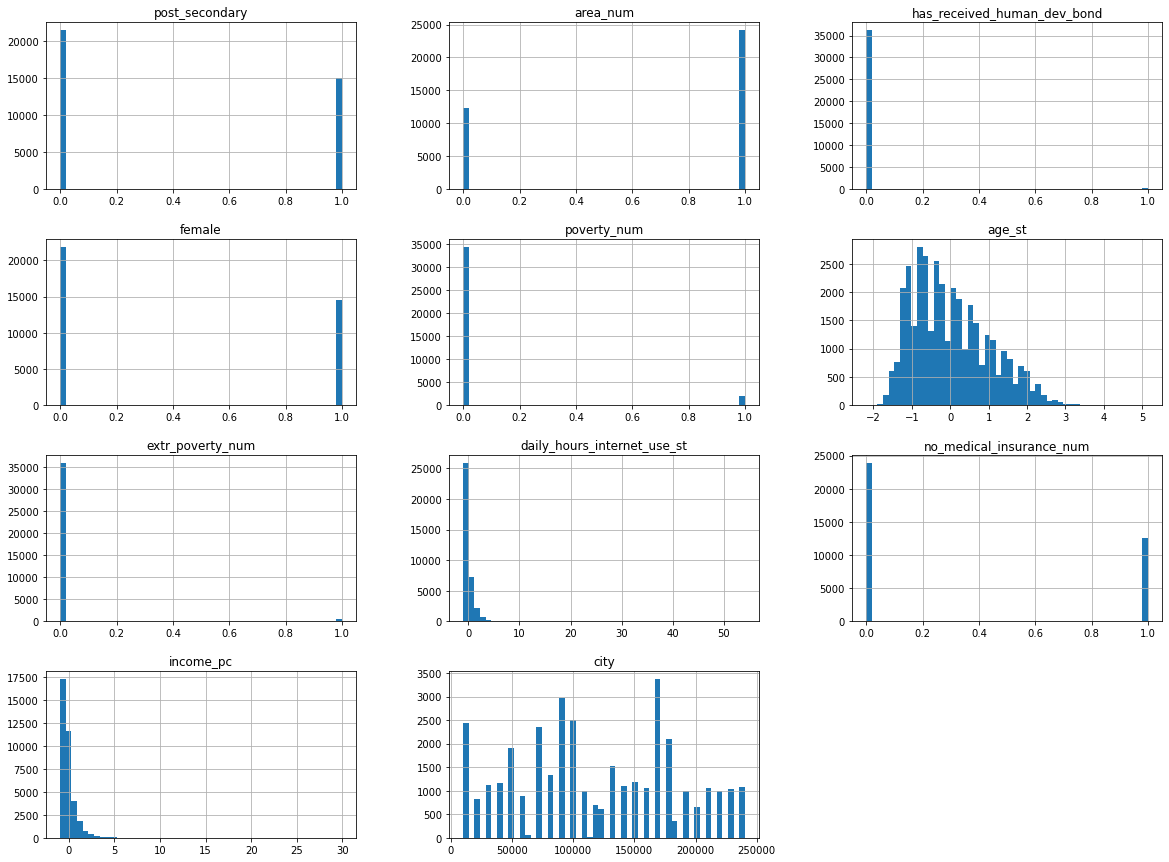

In [7]:
fig =plt.figure()
data_filtered.hist(bins=50, figsize=(20,15))
plt.savefig('Histograms_area.png')
plt.show()

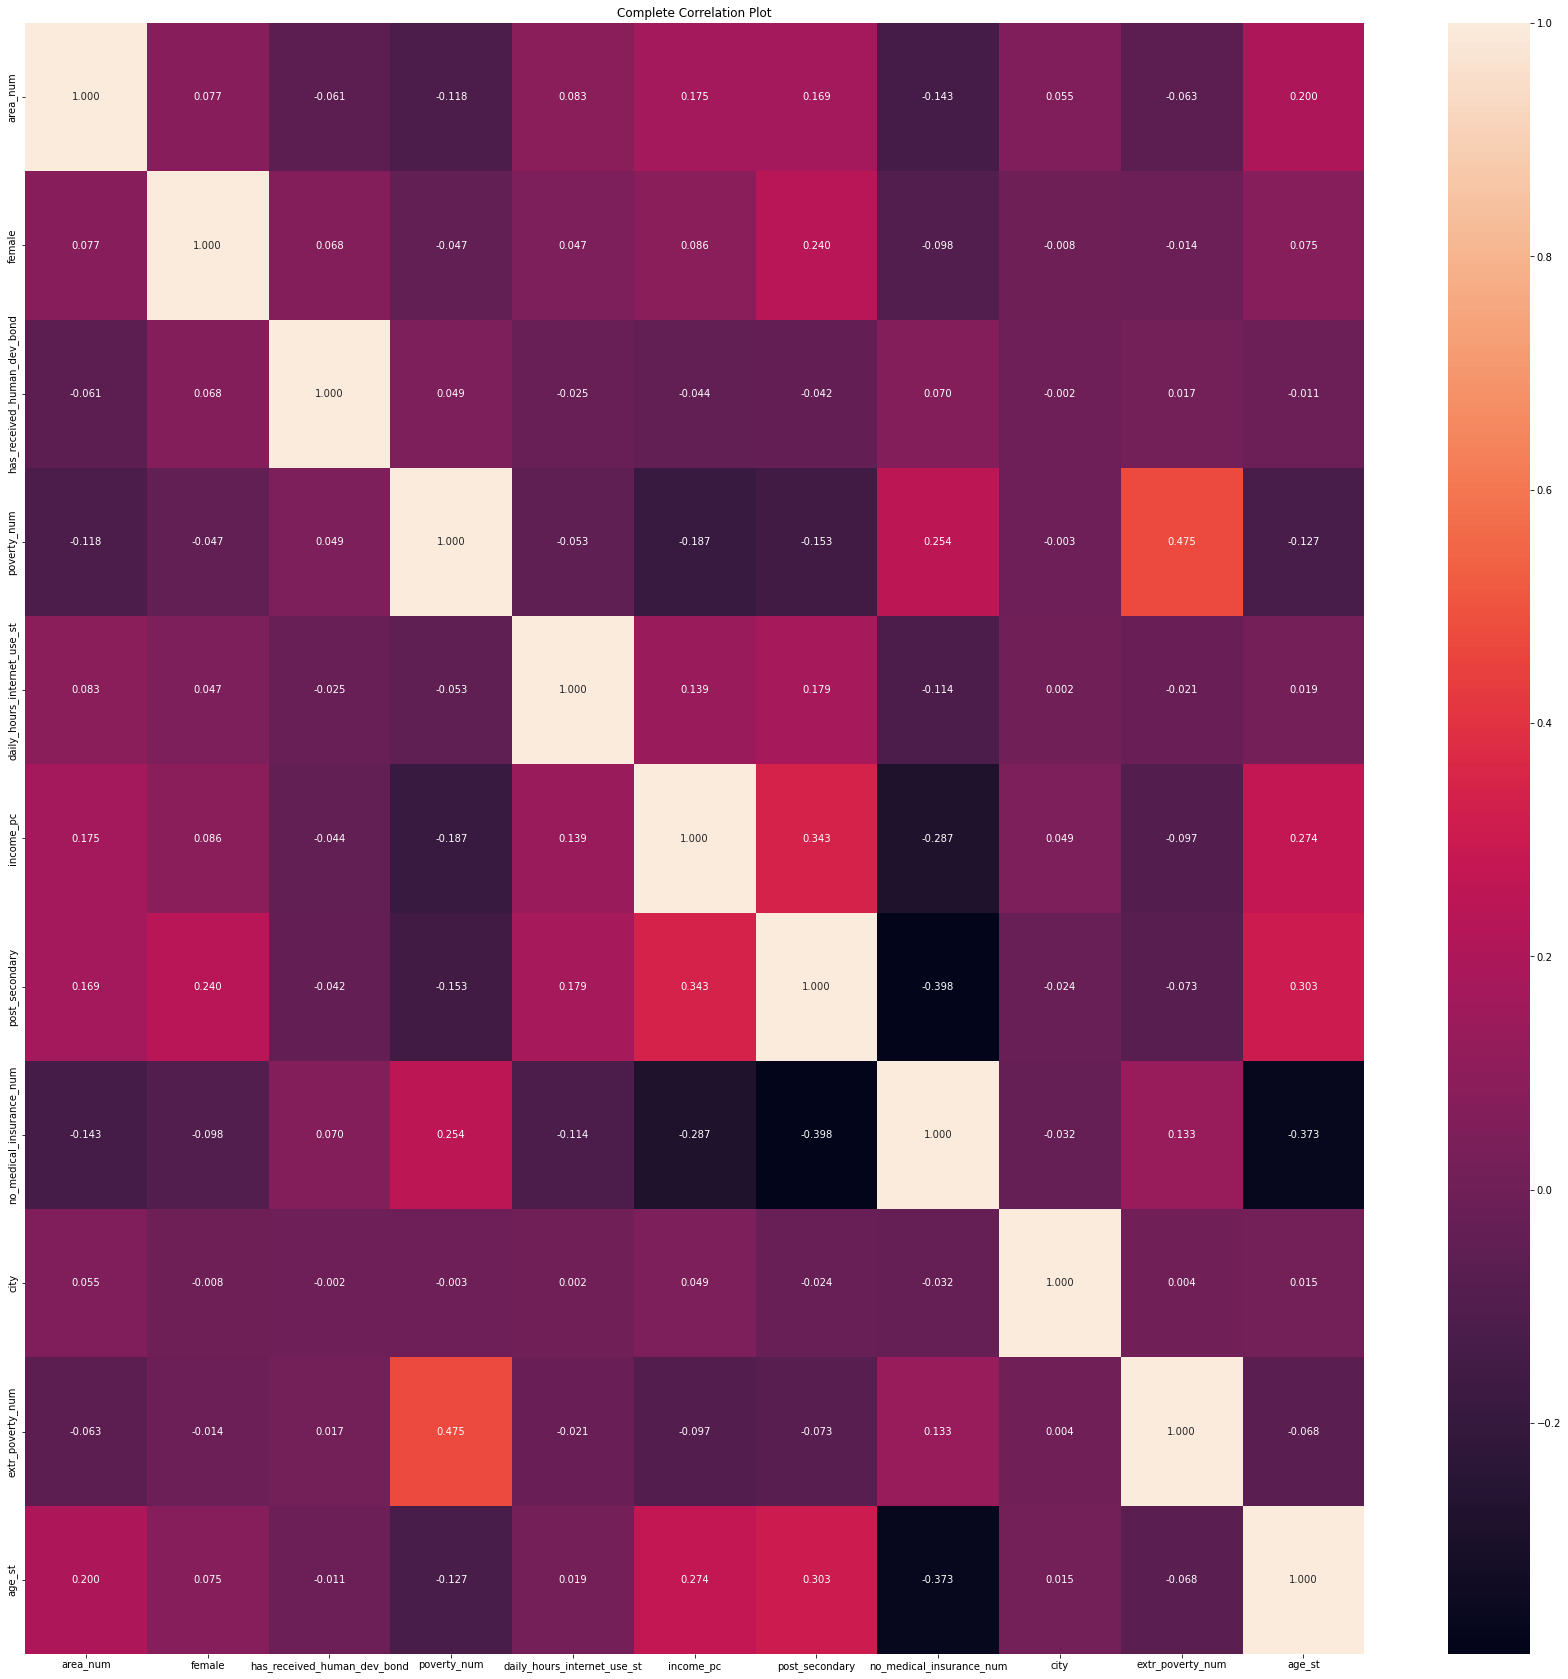

In [8]:
##Correlation Plot for Everything

data_filtered_copy = data_filtered[[ 'area_num','female', 'has_received_human_dev_bond',
       'poverty_num', 'daily_hours_internet_use_st', "income_pc", "post_secondary",
       'no_medical_insurance_num', 'city',"extr_poverty_num","age_st"]]
corr = data_filtered_copy.corr()
plt.figure(figsize=(30,30))
sns.heatmap(corr, 
            annot=True, fmt=".3f",
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
plt.title("Complete Correlation Plot")
plt.savefig('complete_correlations_area.png')
plt.show()

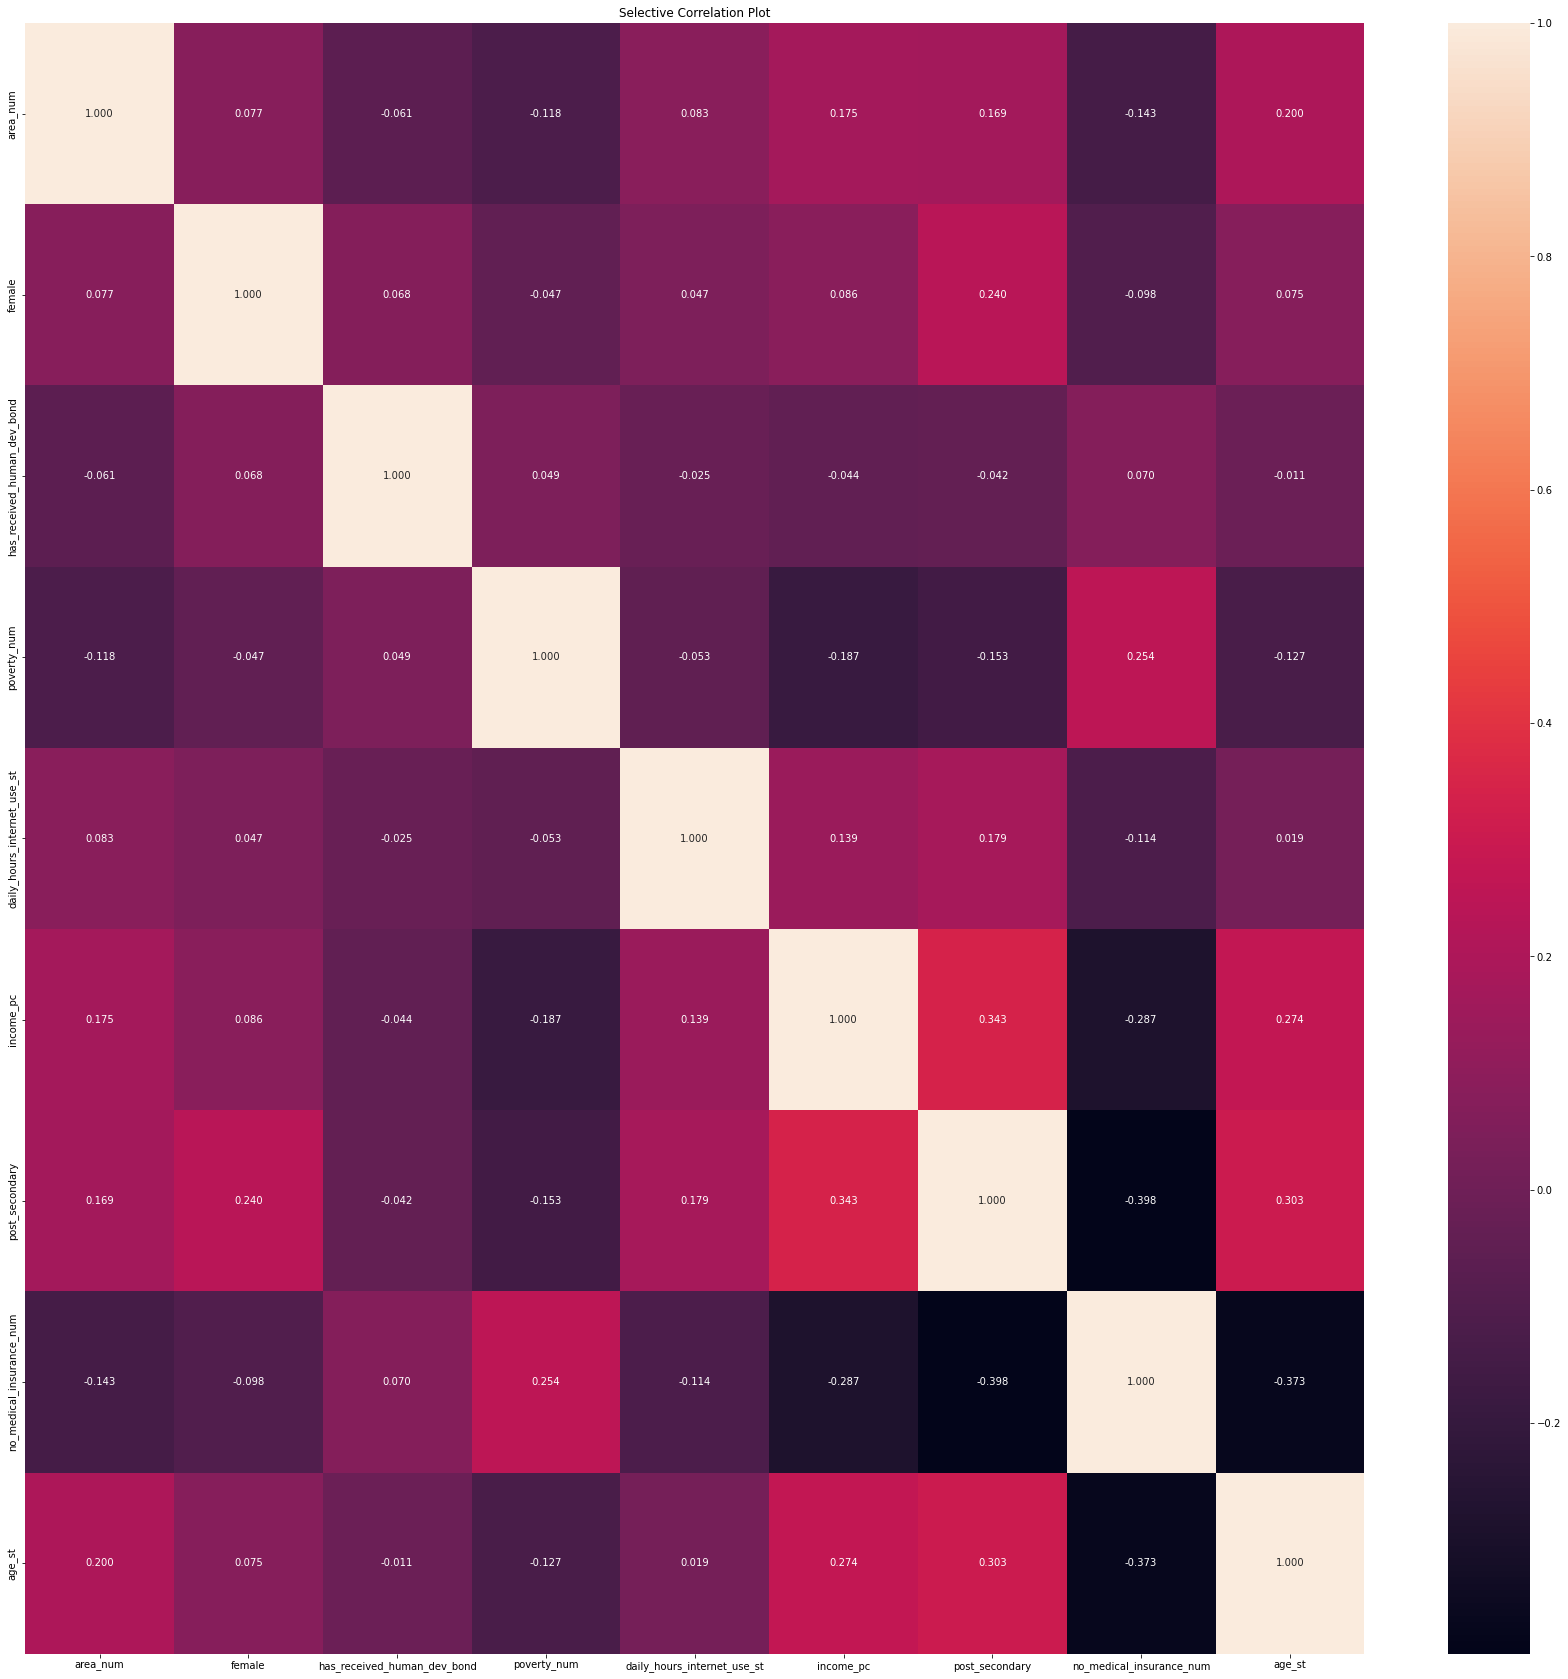

In [9]:
##Focused Correlations

data_filtered_copy = data_filtered[['area_num', 'female', 'has_received_human_dev_bond',
       'poverty_num', 'daily_hours_internet_use_st', "income_pc", "post_secondary",
       'no_medical_insurance_num','age_st']]
corr = data_filtered_copy.corr()
plt.figure(figsize=(30,30))
sns.heatmap(corr, 
            annot=True, fmt=".3f",
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
plt.title("Selective Correlation Plot")
plt.savefig('selective_correlations_area.png')
plt.show()

In [10]:
## Getting x-features and y as the outcomes
x = data_filtered.iloc[:,1:-1]
y = data_filtered["post_secondary"]
x.head()

,area_num,has_received_human_dev_bond,female,poverty_num,age_st,extr_poverty_num,daily_hours_internet_use_st,no_medical_insurance_num,income_pc
429172,0.0,0.0,0,0,0.906881,0.0,-0.585851,0.0,-0.360194
429174,0.0,0.0,0,0,-0.951058,0.0,-0.585851,0.0,-0.360194
429177,0.0,0.0,0,0,-0.243272,0.0,-0.585851,0.0,-0.491811
429178,0.0,1.0,1,0,-0.420219,0.0,-0.585851,1.0,-0.491811
429184,0.0,0.0,0,0,-0.508692,0.0,-0.585851,0.0,-0.373629


In [11]:
## Data preparation (splitting)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.15)

In [12]:
##Number of Data Samples len(X_train)=60636 with total number being 71337

In [13]:
## Starting with a simple Logistic Regression
model=sm.Logit(y,x)
result=model.fit()
result.summary()
with open('summary_logit_area.txt', 'w') as fh:
    fh.write(result.summary().as_text())
fh.close()

Optimization terminated successfully.
         Current function value: 0.513666
         Iterations 6


In [14]:
## Training an SVM with RBF kernel on the data and evaluating accuracy.
svm_linear = svm.SVC(kernel='rbf')
# fit
svm_linear.fit(X_train, y_train)
y_pred = svm_linear.predict(X_test)
# measure accuracy
svm_acc = metrics.accuracy_score(y_true=y_test, y_pred=y_pred)

In [15]:
## Training Gradient Boosting Reg on the data and evaluating accuracy.
regressor=GradientBoostingRegressor()
# fit
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
# measure accuracy
gradboost_acc=metrics.roc_auc_score(y_test,y_pred)


In [16]:
## Training an Random Forest Reg on the data and evaluating accuracy.
regressor=RandomForestRegressor()
# fit
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
# measure accuracy
randomforest_acc = metrics.roc_auc_score(y_test,y_pred)

In [17]:
## Training an AdaBoost Reg on the data and evaluating accuracy.
regressor=AdaBoostRegressor()
# fit
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
# measure accuracy
adaboost_acc = metrics.roc_auc_score(y_test,y_pred)

In [18]:
## Let's compare to when we have the socioeconomic
data_filtered_se = data_filtered[[ "post_secondary",'female', 'has_received_human_dev_bond', "income_pc",
       'age_st']]

x_se = data_filtered_se.iloc[:,1:]
y_se = data_filtered_se["post_secondary"]
x_se.head()

,female,has_received_human_dev_bond,income_pc,age_st
429172,0,0.0,-0.360194,0.906881
429174,0,0.0,-0.360194,-0.951058
429177,0,0.0,-0.491811,-0.243272
429178,1,1.0,-0.491811,-0.420219
429184,0,0.0,-0.373629,-0.508692


In [19]:
## Data preparation (splitting)
X_train, X_test, y_train, y_test = train_test_split(x_se, y_se, test_size = 0.15)

In [20]:
## Training an SVM with RBF kernel on the data and evaluating accuracy.
svm_linear = svm.SVC(kernel='rbf')
# fit
svm_linear.fit(X_train, y_train)
y_pred = svm_linear.predict(X_test)
# measure accuracy
svm_acc_se = metrics.accuracy_score(y_true=y_test, y_pred=y_pred)

## Training Gradient Boosting Reg on the data and evaluating accuracy.
regressor=GradientBoostingRegressor()
# fit
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
# measure accuracy
gradboost_acc_se=metrics.roc_auc_score(y_test,y_pred)

## Training an Random Forest Reg on the data and evaluating accuracy.
regressor=RandomForestRegressor()
# fit
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
# measure accuracy
randomforest_acc_se = metrics.roc_auc_score(y_test,y_pred)

## Training an AdaBoost Reg on the data and evaluating accuracy.
regressor=AdaBoostRegressor()
# fit
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
# measure accuracy
adaboost_acc_se = metrics.roc_auc_score(y_test,y_pred)

In [21]:
## Scores' Display

scores=[[svm_acc_se,svm_acc],[gradboost_acc_se,gradboost_acc],[randomforest_acc_se,randomforest_acc],[adaboost_acc_se,adaboost_acc]]
with open('model_comparisons_area.txt', 'w') as fh:
    fh.write(str(scores))
fh.close()

In [22]:
scores

[[0.7570435418953531, 0.7713135748261983],
 [0.8286271855947507, 0.8503741464098474],
 [0.761815532174238, 0.803649889070768],
 [0.8229876718567464, 0.8356655091341382]]

In [23]:
## Post secondary variable with city
city_col = data_filtered['city']
post_sec_col = data_filtered['post_secondary']
city_post_sec = pd.concat([city_col,post_sec_col], axis=1)
city_post_sec.describe()

,city,post_secondary
count,36435.000000,36435.000000
mean,118537.329820,0.411857
std,65216.163826,0.492176
min,10150.000000,0.000000
25%,70150.000000,0.000000
50%,110156.000000,0.000000
75%,170184.000000,1.000000
max,240352.000000,1.000000


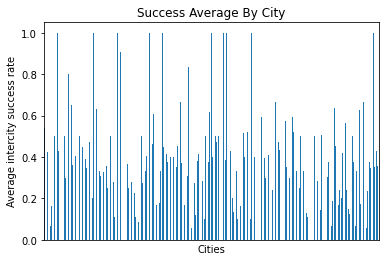

In [24]:
## Success rate by city

df=city_post_sec.groupby("city").describe()
df = df["post_secondary"]
plt.figure()
df["mean"].plot.bar()
plt.ylabel('Average intercity success rate')
ax = plt.gca()
#ax.axes.xaxis.set_visible(False)
ax.axes.xaxis.set_ticks([])
plt.xlabel('Cities')
plt.title('Success Average By City')
plt.savefig('successaveragebycity_area.png')
plt.show()

In [25]:
## We construct a DF with internet usage, post secondary details and city, the group by city
internet= data_filtered['daily_hours_internet_use_st']
city_ps_int = pd.concat([city_col,post_sec_col,internet], axis=1)
city_ps_int.describe()
df=city_ps_int.groupby("city").describe()

## We then compute the correlation between post secondary success and internet usage on a city level
df_ps = df["post_secondary"]
df_ps['post_secondary'] = df_ps["mean"]
df_int = df["daily_hours_internet_use_st"]
df_int['internet'] = df_int["mean"]
corr_df = pd.concat([df_ps['post_secondary'],df_int['internet']],axis=1)
dfi.export(corr_df.corr(),'city_ps_internet_corr_area.png')
corr_df.corr()

/var/folders/f7/7hvkcy795f15nmmvsk3btj940000gn/T/ipykernel_18669/3428473063.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ps['post_secondary'] = df_ps["mean"]
/var/folders/f7/7hvkcy795f15nmmvsk3btj940000gn/T/ipykernel_18669/3428473063.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_int['internet'] = df_int["mean"]
[0308/104817.580330:INFO:headless_shell.cc(659)] Written to file /var/folders/f7/7hvkcy795f15nmmvsk3btj940000gn/T/tmpglq00f0s/temp.png.


,post_secondary,internet
post_secondary,1.000000,0.159646
internet,0.159646,1.000000


In [26]:
## We construct a DF with internet usage, post secondary details and city, the group by city
income= data_filtered['income_pc']
city_ps_inc = pd.concat([city_col,post_sec_col,income], axis=1)
df=city_ps_inc.groupby("city").describe()

## We then compute the correlation between post secondary success and internet usage on a city level
df_ps = df["post_secondary"]
df_ps['post_secondary'] = df_ps["mean"]
df_inc = df["income_pc"]
df_inc['income_pc'] = df_inc["mean"]
corr_df = pd.concat([df_ps['post_secondary'],df_inc['income_pc']],axis=1)
dfi.export(corr_df.corr(),'city_ps_income_corr_area.png')
corr_df.corr()

/var/folders/f7/7hvkcy795f15nmmvsk3btj940000gn/T/ipykernel_18669/4090682440.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ps['post_secondary'] = df_ps["mean"]
/var/folders/f7/7hvkcy795f15nmmvsk3btj940000gn/T/ipykernel_18669/4090682440.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inc['income_pc'] = df_inc["mean"]
[0308/104820.906268:INFO:headless_shell.cc(659)] Written to file /var/folders/f7/7hvkcy795f15nmmvsk3btj940000gn/T/tmpf2mv_613/temp.png.


,post_secondary,income_pc
post_secondary,1.000000,0.382631
income_pc,0.382631,1.000000


In [27]:
## We construct a DF with internet usage, post secondary details and city, the group by city

age= data_filtered['age_st']
city_ps_age = pd.concat([city_col,post_sec_col,age], axis=1)
df=city_ps_age.groupby("city").describe()

## We then compute the correlation between post secondary success and internet usage on a city level
df_ps = df["post_secondary"]
df_ps['post_secondary'] = df_ps["mean"]
df_age = df["age_st"]
df_age['age'] = df_age["mean"]
corr_df = pd.concat([df_ps['post_secondary'],df_age['age']],axis=1)
dfi.export(corr_df.corr(),'city_ps_age_corr_area.png')
corr_df.corr()


/var/folders/f7/7hvkcy795f15nmmvsk3btj940000gn/T/ipykernel_18669/1956184123.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ps['post_secondary'] = df_ps["mean"]
/var/folders/f7/7hvkcy795f15nmmvsk3btj940000gn/T/ipykernel_18669/1956184123.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_age['age'] = df_age["mean"]
[0308/104824.469845:INFO:headless_shell.cc(659)] Written to file /var/folders/f7/7hvkcy795f15nmmvsk3btj940000gn/T/tmpfy4e2kbk/temp.png.


,post_secondary,age
post_secondary,1.000000,0.452897
age,0.452897,1.000000


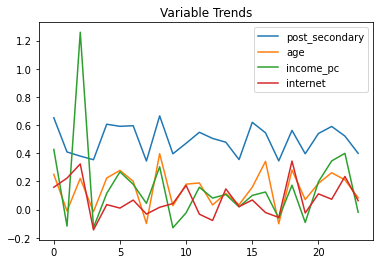

In [33]:
## Non binary trends' plots
df_count=df_inc['count']
sort_count= pd.concat([df_count,df_ps['post_secondary'],df_age['age'],df_inc['income_pc'],df_int['internet']],axis=1)
sort_count=sort_count.sort_values('count',ascending=True) 
sort_count=sort_count[sort_count['count']>250]
for column in sort_count:
    if not column=='count':
        plt.plot(sort_count[column].values,label=column)
plt.legend()
plt.title('Variable Trends')
plt.savefig('trends_area.png')
plt.show()

/var/folders/f7/7hvkcy795f15nmmvsk3btj940000gn/T/ipykernel_18669/3975495021.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ps['post_secondary'] = df_ps["mean"]
/var/folders/f7/7hvkcy795f15nmmvsk3btj940000gn/T/ipykernel_18669/3975495021.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_area['area'] = df_area["mean"]
/var/folders/f7/7hvkcy795f15nmmvsk3btj940000gn/T/ipykernel_18669/3975495021.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

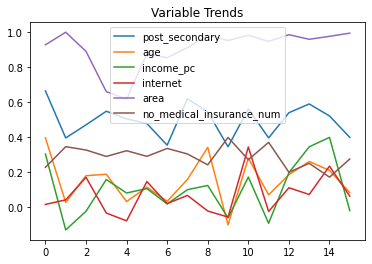

In [37]:
##Plots for all trends presumed to be interested/informative.

area= data_filtered['area_num']
nomed_insur = data_filtered["no_medical_insurance_num"]
city_ps_age = pd.concat([city_col,post_sec_col,area,nomed_insur], axis=1)
df=city_ps_age.groupby("city").describe()

## We then compute the correlation between post secondary success and internet usage on a city level
df_ps = df["post_secondary"]
df_ps['post_secondary'] = df_ps["mean"]
df_area = df["area_num"]
df_area['area'] = df_area["mean"]

df_med = df['no_medical_insurance_num']
df_med['no_medical_insurance_num'] = df_med["mean"]

## Non binary
df_count=df_inc['count']
sort_count= pd.concat([df_count,df_ps['post_secondary'],df_age['age'],df_inc['income_pc'],df_int['internet'], df_area['area'],df_med['no_medical_insurance_num']],axis=1)
sort_count=sort_count.sort_values('count',ascending=True) 
sort_count=sort_count[sort_count['count']>400]
for column in sort_count:
    if not column=='count':
        plt.plot(sort_count[column].values,label=column)
plt.legend()
plt.title('Variable Trends')
plt.savefig('trends_area_wf_med.png')
plt.show()